<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

<div style='border:solid black 5px; padding: 40px'>

# <font color='black'> **_Проект по разработке телеграм-бота для определения повреждений авто по фотографии_**</font>
    
</div>


_**Описание проекта:** В связи с высокой востребованностью телеграм-ботов для различных целей было принято решение разработать телеграм-бот с нуля в связке с готовой предобученной моделью, а также запуск этого бота в Docker-контейнере._

_Данные для этого проекта не исследуются и модель не обучается, а интегрируется готовая c известной платформы для разработки и развертывания ML-моделей **Roboflow**. Среди множества была выбрана модель для определения повреждений автомобиля по фотографии car-damage-coco-dataset Computer Vision Project, обученная на 4031 фото._

_Предварительно создаем в мессенджере **Telegram** бота с помощью **BotFather** и получаем свой токен для доступа к **HTTP API**. Также необходимо зарегистрироваться на сайте [Roboflow](https://roboflow.com/), чтобы в своем ЛК получить **API-Key** и другие данные для интеграции модели в бот._

_**Цель проекта:** Создать телеграм-бот, который распознаёт повреждения автомобиля по фото._

In [1]:
# установки необходимых библиотек

!pip install telebot
!pip install opencv-python
!pip install supervision
!pip install inference

In [2]:
# импорты необходимых библиотек

import telebot
import requests
import cv2
from inference import get_model
import supervision as sv

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


In [3]:
# создаем переменную для API-TOKEN телеграм-бота

API_TOKEN = '***YOUR-API-TOKEN***'
bot = telebot.TeleBot(API_TOKEN)

# загружаем предобученную модель
# на вкладке API Docs возьмем необходимые данные
model = get_model(model_id="car-damage-coco-dataset/4", api_key="***YOUR-API-KEY***")

# начало работы с ботом (команды '/start' и '/help')
@bot.message_handler(commands=['help', 'start'])
def send_welcome(message):
    bot.reply_to(message, """\
Привет! Я - бот для распознавания повреждений автомобиля.
Пришли мне фотографию авто и я определю, есть ли на нем повреждения.\
""")

# настройка обработки фотосообщений
@bot.message_handler(content_types=['photo'])
def handle_photo(message):
    photo = message.photo[-1]
    file_info = bot.get_file(photo.file_id)
    downloaded_file = bot.download_file(file_info.file_path)
    save_path = 'photo.jpg'

    with open(save_path, 'wb') as new_file:
        new_file.write(downloaded_file)

    bot.reply_to(message, 'Фотография сохранена. Обрабатываю...')

    # загрузка фото для обработки
    image = cv2.imread(save_path)

    # вывод по выбранному изображению
    results = model.infer(image)[0]

    # обнаружение повреждений
    detections = sv.Detections.from_inference(results)
    print(detections)

    # создание аннотаторов
    bounding_box_annotator = sv.BoundingBoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    # аннотирование изображения с результатами вывода
    annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # сохранение аннотированного изображения
    annotated_image_path = 'annotated_photo.jpg'
    cv2.imwrite(annotated_image_path, annotated_image)

    # отправка аннотированного изображения пользователю
    with open(annotated_image_path, 'rb') as photo:
        bot.send_photo(message.chat.id, photo)

bot.infinity_polling()

Detections(xyxy=array([[156., 159., 800., 570.]]), mask=array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]]), confidence=array([0.621]), class_id=array([1]), tracker_id=None, data={'class_name': array(['Car-Damage'], dtype='<U10')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


Detections(xyxy=array([[112.,  81., 283., 215.]]), mask=array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]]), confidence=array([0.641]), class_id=array([1]), tracker_id=None, data={'class_name': array(['Car-Damage'], dtype='<U10')})


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
2024-08-17 17:14:43,094 (__init__.py:1112 MainThread) ERROR - TeleBot: "Infinity polling: polling exited"
ERROR:TeleBot:Infinity polling: polling exited
2024-08-17 17:14:43,098 (__init__.py:1114 MainThread) ERROR - TeleBot: "Break infinity polling"
ERROR:TeleBot:Break infinity polling


На выходе получаем координаты обнаруженного повреждения в виде рамки, а также уверенность модели в найденном повреждении confidence=array([0.641]) и наименование класса повреждения class_id=array([1])


В чате с телеграм-ботом получаем следующую беседу:

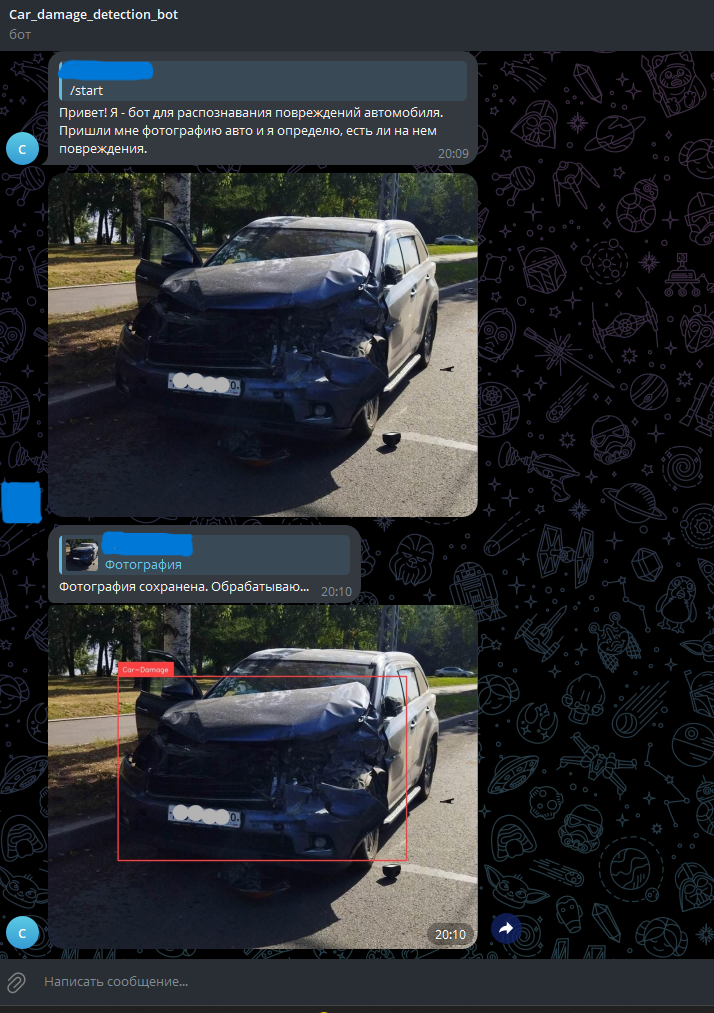

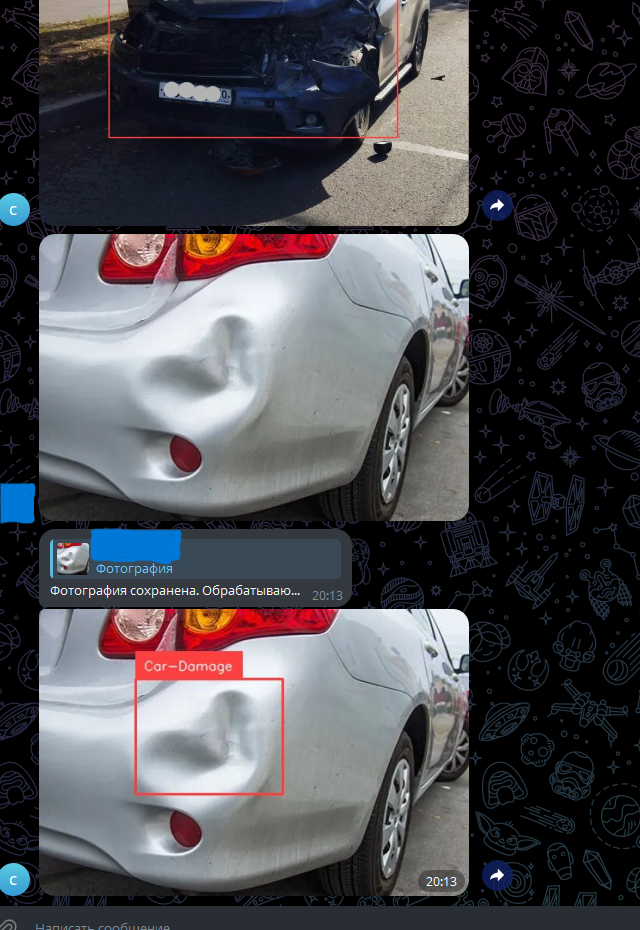